## Preparando Ambiente

In [44]:
using Pkg
Pkg.activate("..\\..");
using JuMP;
using Plots;
using GLPK;
using CSV;
using DataFrames;

  Activating project at `c:\Users\thiag\Documents\GitHub\MestradoPuc.jl`


## Analise exploratoria

In [45]:
df = CSV.read("eolica.csv", DataFrame);
data = df[:,2];

In [46]:
function L(data::Vector{Float64}, k::Int = 0)
    x = data[1:end-k]
    y = data[k+1:end]

    return x, y
end

function plot_shift(data::Vector{Float64}, k::Int = 0)
    x, y = L(data, k)
    p = plot(x, y, seriestype = :scatter, title = "k = $k")

    return p
end

plot_shift (generic function with 2 methods)

In [ ]:
plot(
    plot_shift(data, 1),
    plot_shift(data, 2),
    plot_shift(data, 3),
    plot_shift(data, 4),
    layout = (2, 2), legend = false)

In [ ]:
plot(
    plot_shift(data, 21),
    plot_shift(data, 22),
    plot_shift(data, 23),
    plot_shift(data, 24),
    layout = (2, 2), legend = false)

In [ ]:
plot(
    plot_shift(data, 11),
    plot_shift(data, 12),
    plot_shift(data, 13),
    plot_shift(data, 14),
    layout = (2, 2), legend = false)

## Modelo Autoregressivo sem sazonalidade

In [47]:
function auto_regression_model(data::Vector{Float64}, K::Vector{Int} = [1])

    n = length(K)
    N = length(data)
    k_max = maximum(K)

    model = Model(GLPK.Optimizer)
    @variable(model, beta[1:n+1])
    @variable(model, error[1:N-k_max])

    @expression(model, AR[i = 1:N-k_max], 
        beta[1] + 
        sum(beta[j+1]*data[i + k_max - K[j]] for j = 1:n))

    @constraint(model, [i = 1:N-k_max], error[i] >= + data[i + k_max] - AR[i] )
    @constraint(model, [i = 1:N-k_max], error[i] >= - data[i + k_max] + AR[i] )

    @objective(model, Min, sum(error))

    optimize!(model)
    
    return model
end

auto_regression_model (generic function with 2 methods)

In [48]:
model = auto_regression_model(data,[1])
AR = value.(model[:AR])
r_square(data[2:end], AR)

0.9239333453105907

In [33]:
model = auto_regression_model(data,[1, 24])
AR = value.(model[:AR])
r_square(data[25:end], AR)

0.9216678882602514

In [49]:
model = auto_regression_model(data,[1, 2, 23, 24])
AR = value.(model[:AR])
r_square(data[25:end], AR)

0.9570746098894178

In [50]:
model = auto_regression_model(data,[1, 12, 24])
AR = value.(model[:AR])
r_square(data[25:end], AR)

0.9284953526327525

## Modelo com sazonalidade

In [7]:
function agregate(data::Vector{Float64}, s::Int)
    agregated = Float64[]
    location = 1
    size = length(data)

    while true
        if location+s-1 <= size
            interval = data[location:location+s-1]
            value =  sum(interval) / s
            push!(agregated, value)
            location = location+s
        else
            break
        end
    end

    return agregated
end

agregate (generic function with 1 method)

In [ ]:
y = agregate(data,720)
plot(y, title = "Agregação mensal")

In [10]:
function season_model(data::Vector{Float64}, S::Vector{Int} = [8760], M::Vector{Int} = [1])

    N = length(data)
    m = length(S)

    model = Model(GLPK.Optimizer)
    @variable(model, error[1:N])
    @variable(model, theta[1:sum(M)])
    @variable(model, phi[1:sum(M)])
        
    @expression(model, ST[i = 1:N], sum(sum(
        theta[(j != 1 ? sum(M[l] for l = 1:j-1) : 0) + k]*cos(2*pi*k*i/S[j]) + 
        phi[(j != 1 ? sum(M[l] for l = 1:j-1) : 0) + k]*sin(2*pi*k*i/S[j]) 
        for k in 1:M[j]) for j = 1:m))

    @constraint(model, [i = 1:N], error[i] >= + data[i] - ST[i])
    @constraint(model, [i = 1:N], error[i] >= - data[i] + ST[i])

    @objective(model, Min, sum(error))

    optimize!(model)

    write_to_file(model, "teste.lp")
    
    return model
end

season_model (generic function with 3 methods)

In [38]:
model = season_model(data,[24,8760],[5,5])
@show value.(model[:theta])
@show value.(model[:phi])
# ST = @show value.(model[:ST])

value.(model[:theta]) = [0.05247660114723207, -0.043629283321316416, -0.009516099927095241, 0.005018020299739801, -0.008521334101956659, -0.1671549290856886, -0.07430922078741287, -0.05085912163109382, 0.02156042908576376, -0.10076936432595758]
value.(model[:phi]) = [0.02568844105425186, -0.02231414175622444, -0.00032453877560926006, -0.0004677410694794116, -0.011095992516308956, -0.0789753081058857, 0.023943259127646093, 0.015745060708418048, -0.022661213788243758, -0.0404623434366762]


10-element Vector{Float64}:
  0.02568844105425186
 -0.02231414175622444
 -0.00032453877560926006
 -0.0004677410694794116
 -0.011095992516308956
 -0.0789753081058857
  0.023943259127646093
  0.015745060708418048
 -0.022661213788243758
 -0.0404623434366762

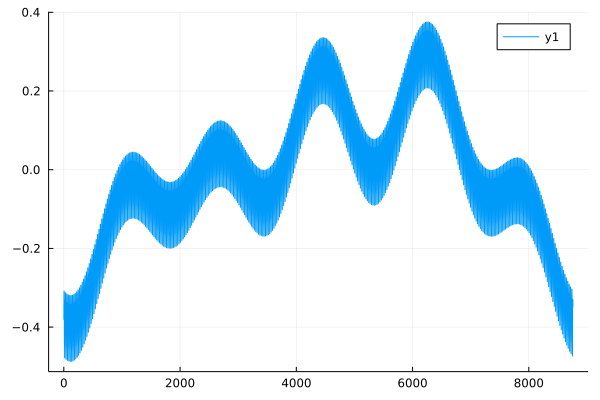

In [14]:
plot(ST)

## Modelo Completo

In [51]:
function complete_model(data::Vector{Float64}, K::Vector{Int} = [1], S::Vector{Int} = [8760], M::Vector{Int} = [1])

    n = length(K)
    N = length(data)
    k_max = maximum(K)
    m = length(S)

    model = Model(GLPK.Optimizer)
    @variable(model, beta[1:n+1])
    @variable(model, error[1:N-k_max])
    @variable(model, theta[1:sum(M)])
    @variable(model, phi[1:sum(M)])

    @expression(model, AR[i = 1:N-k_max], 
        beta[1] + 
        sum(beta[j+1]*data[i + k_max - K[j]] for j = 1:n))
        
    @expression(model, ST[i = 1:N-k_max], sum(sum(
        theta[(j != 1 ? sum(M[l] for l = 1:j-1) : 0) + k]*cos(2*pi*k*i/S[j]) + 
        phi[(j != 1 ? sum(M[l] for l = 1:j-1) : 0) + k]*sin(2*pi*k*i/S[j]) 
        for k in 1:M[j]) for j = 1:m))

    @expression(model, estimate[i = 1:N-k_max], AR[i] + ST[i])

    @constraint(model, [i = 1:N-k_max], error[i] >= + data[i + k_max] - estimate[i])
    @constraint(model, [i = 1:N-k_max], error[i] >= - data[i + k_max] + estimate[i])

    @objective(model, Min, sum(error))

    optimize!(model)
    
    return model
end

complete_model (generic function with 4 methods)

In [ ]:
model = complete_model(data)

In [ ]:
function f(data, beta, theta, phi)
    n = length(data)
    y = zeros(n)
        
    y[1] = 0.65
    for i = 2:n
        y[i] = beta[1] + y[i-1]*beta[2] + theta[1]*cos(2*pi*i/8760) + phi[1]*sin(2*pi*i/8760)
    end
    return y
end


In [ ]:
plot(y)

In [ ]:
plot(data)

In [ ]:
]st

## Métricas

In [52]:
function r_square(data::Vector{Float64}, estimative::Vector{Float64})
    output = 1.0
    n = length(data)
    average = sum(data) / n
    
    output = 1.0 - sum((data[i] - estimative[i])^2 for i in 1:n) / sum((data[i] - average)^2 for i in 1:n) 

    return output
end

function mae(data::Vector{Float64}, estimative::Vector{Float64}, T::Int)
    output = 0.0

    K = length(data) - T
    
    for i in (T+1):(T+K)
        output += abs(data[i] - estimative[i]) / K
    end
    
    return output
end

mae (generic function with 1 method)

In [79]:
function forecast(data::Vector{Float64}, K::Vector{Int} = [1], S::Vector{Int} = [8760], M::Vector{Int} = [1], T::Int = 0)
    model = complete_model(data[1:T], K, S, M)

    beta = value.(model[:beta])
    theta = value.(model[:theta])
    phi = value.(model[:phi])

    n_forecast = length(data) - T

    output = zeros(length(data))
    n = length(beta) - 1
    m = length(S)

    for i in 1:n_forecast #T+1:length(data)
        AR = beta[1] + sum(beta[j+1]*data[T + i - K[j]] for j = 1:n)
        ST = sum(sum(theta[(j != 1 ? sum(M[l] for l = 1:j-1) : 0) + k]*cos(2*pi*k*(T+i)/S[j]) + 
            phi[(j != 1 ? sum(M[l] for l = 1:j-1) : 0) + k]*sin(2*pi*k*(T+i)/S[j]) 
            for k in 1:M[j]) for j = 1:m)
        output[T+i] = AR + ST
    end

    return data, output
end
    
    

forecast (generic function with 5 methods)

In [80]:
x, y = forecast(data,[1,24],[24, 8760],[1,1],7000 )


([0.65, 0.58, 0.53, 0.51, 0.61, 0.9, 0.86, 0.74, 0.6, 0.46  …  0.13, 0.14, 0.14, 0.15, 0.2, 0.24, 0.28, 0.33, 0.41, 0.55], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.11928367644395653, 0.13713227605433584, 0.15524444973778231, 0.1637618387242393, 0.18369431886080875, 0.23795202607418436, 0.2783449520163245, 0.317898455386012, 0.3665312076095465, 0.4425858800715995])